In [1]:
import os
import glob
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import transforms

In [2]:
np.random.seed(42)

In [3]:
class VisDrone(Dataset):
    def __init__(self, root):
        self.root = root
        self.image_files = sorted(glob.glob(os.path.join(root, "images", "*.jpg")))
        self.label_files = sorted(glob.glob(os.path.join(root, "annotations", "*.txt")))
        assert len(self.image_files) == len(self.label_files), "Number of images and labels must be the same"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = self._load_image(idx)
        bboxes = self._load_annotations(idx)
        return image, bboxes, len(bboxes)
    
    def _load_image(self, idx):
        image = cv2.imread(self.image_files[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    
    def _load_annotations(self, idx):
        full_annotations = np.loadtxt(self.label_files[idx], delimiter=",", dtype=np.uint32)
        only_car_annotations = full_annotations[full_annotations[:, 5] == 4]
        bboxes = only_car_annotations[:, :4]
        return bboxes

In [4]:
visdrone_categories = {
    1: "pedestrian",
    2: "people",
    3: "bicycle",
    4: "car",
    5: "van",
    6: "truck",
    7: "tricycle",
    8: "awning-tricycle",
    9: "bus",
    10: "motor",
}
visdrone = VisDrone("visdrone-dataset")

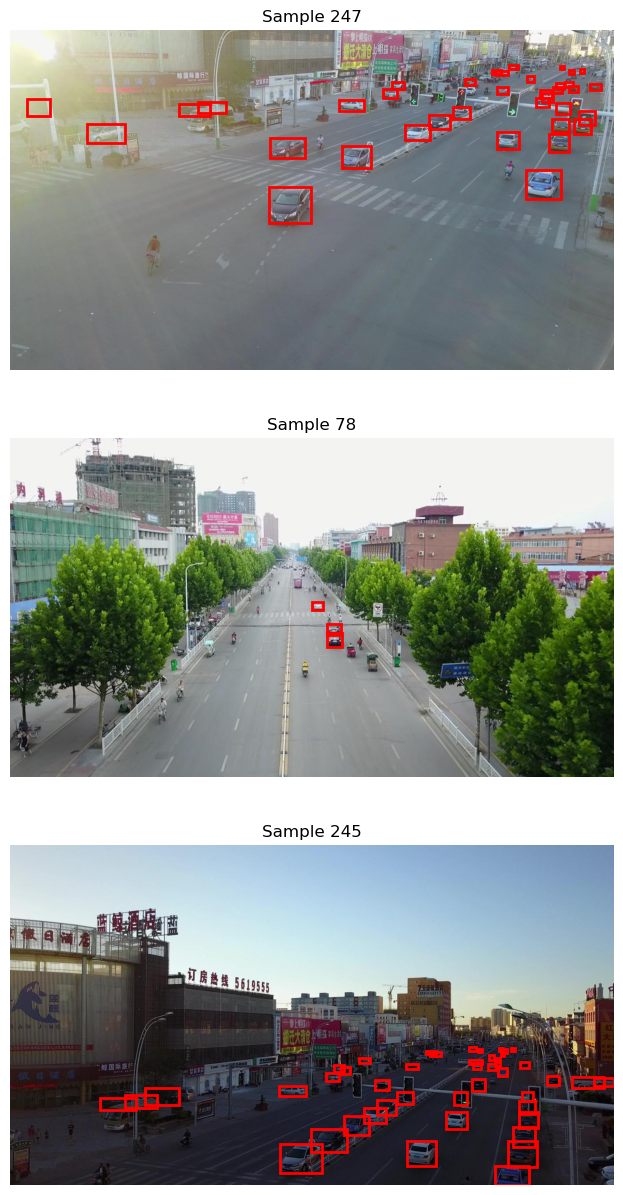

In [5]:
num_samples = 3
fig, axes = plt.subplots(num_samples, 1, figsize=(15, 5*num_samples))    
src_indices = np.random.choice(len(visdrone), num_samples, replace=False)
for i, idx in enumerate(src_indices):
    src_patch, bboxes, num_obj = visdrone[idx]
    ax = axes[i] if num_samples > 1 else axes
    ax.imshow(src_patch)
    ax.set_title(f"Sample {idx}")
    for bbox in bboxes:
        x, y, w, h = bbox
        rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
    ax.axis('off')

In [6]:
class ImageGenerator(Dataset):
    def __init__(self, dataset: Dataset, dataset_size: int, patch_size: tuple[int, int]):
        self.dataset = dataset
        self.dataset_size = dataset_size
        self.patch_size = patch_size

    def __len__(self):
        return self.dataset_size
    
    def __getitem__(self, idx: int):
        background = self._create_background()
        num_obj = np.random.randint(10, 20)
        image, bboxes = self._add_objects(background, num_obj)
        return image, bboxes, len(bboxes)

    def _add_objects(self, background:np.ndarray, num_obj:int) -> tuple[np.ndarray, np.ndarray]:
        result_image = background.copy()
        bg_h, bg_w = background.shape[:2]
        max_attempts = 10 * num_obj
        attempts = 0
        placed_boxes = []
        while len(placed_boxes) < num_obj and attempts < max_attempts:
            attempts += 1
            
            img_idx = np.random.choice(self.dataset_size)
            image, bboxes, num_bboxes = self.dataset[img_idx]
            
            if num_bboxes == 0:
                continue
            
            box_idx = np.random.choice(num_bboxes)
            x, y, w, h = bboxes[box_idx]
                
            car = image[y:y+h, x:x+w]
            
            scale = np.random.uniform(0.8, 1.2)
            new_w, new_h = int(w * scale), int(h * scale)
            
            if new_w > bg_w // 2 or new_h > bg_h // 2:
                continue

            if new_w > 0 and new_h > 0:
                car = cv2.resize(car, (new_w, new_h))
            else:
                continue
            
            max_x = bg_w - new_w
            max_y = bg_h - new_h
            
            if max_x <= 0 or max_y <= 0:
                continue
                
            pos_x = np.random.randint(0, max_x)
            pos_y = np.random.randint(0, max_y)
            
            new_box = np.array([pos_x, pos_y, new_w, new_h])
            
            overlap_ok = True
            for placed_box in placed_boxes:
                overlap_ratio = self._calculate_overlap(new_box, placed_box)
                if overlap_ratio > 0.5:
                    overlap_ok = False
                    break
            
            if not overlap_ok:
                continue
            
            mask = np.ones(car.shape, dtype=np.uint8) * 255
            center = (pos_x + new_w // 2, pos_y + new_h // 2)
            
            result_image = cv2.seamlessClone(
                car, 
                result_image, 
                mask, 
                center, 
                cv2.NORMAL_CLONE
            )
            
            placed_boxes.append(new_box)
        
        return result_image, np.array(placed_boxes)
     
    def _calculate_overlap(self, box1, box2):
        x1_1, y1_1, w1, h1 = box1
        x2_1, y2_1 = x1_1 + w1, y1_1 + h1
        
        x1_2, y1_2, w2, h2 = box2
        x2_2, y2_2 = x1_2 + w2, y1_2 + h2
        
        x_left = max(x1_1, x1_2)
        y_top = max(y1_1, y1_2)
        x_right = min(x2_1, x2_2)
        y_bottom = min(y2_1, y2_2)
        
        if x_right < x_left or y_bottom < y_top:
            return 0.0
        
        intersection_area = (x_right - x_left) * (y_bottom - y_top)
        
        box1_area = w1 * h1
        box2_area = w2 * h2
        
        smaller_area = min(box1_area, box2_area)
        if smaller_area == 0:
            return 0.0
            
        return intersection_area / smaller_area
    

    def _create_background(self):
        h, w = self.patch_size
        background = np.zeros((2 * h, 2 * w, 3), dtype=np.uint8)
        src_indices = np.random.choice(self.dataset_size, 4, replace=False)
        ref_indices = np.random.choice(self.dataset_size, 4, replace=False)
        for i, (src_idx, ref_idx) in enumerate(zip(src_indices, ref_indices)):
            src_patch, _, _ = self.dataset[src_idx]
            ref_patch, _, _ = self.dataset[ref_idx]

            src_patch = cv2.resize(src_patch, (w, h))
            ref_patch = cv2.resize(ref_patch, (w, h))

            src_patch = self._color_correction(src_patch, ref_patch)
            
            x, y = i % 2 * w, i // 2 * h
            background[y:y+h, x:x+w] = cv2.resize(src_patch, (w, h))
        return background
    
    def _color_correction(self, src: np.ndarray, ref: np.ndarray) -> np.ndarray:
        src = src.astype(float)
        ref = ref.astype(float)
        result = np.zeros_like(src)
        
        for i in range(3):
            source_mean = np.mean(src[:, :, i])
            source_std = np.std(src[:, :, i])
            target_mean = np.mean(ref[:, :, i])
            target_std = np.std(ref[:, :, i])
            
            if source_std > 1e-6:
                result[:, :, i] = (src[:, :, i] - source_mean) / source_std * target_std + target_mean
            else:
                result[:, :, i] = src[:, :, i]
        
        result = np.clip(result, 0, 255).astype(np.uint8)
        return result

(-0.5, 1023.5, 1023.5, -0.5)

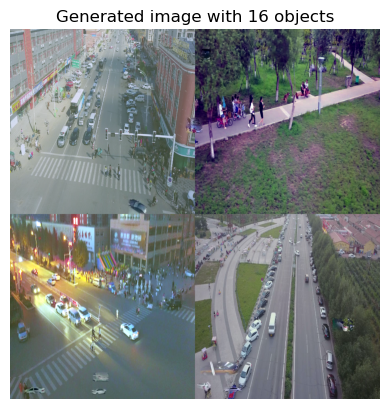

In [7]:
img_gen = ImageGenerator(visdrone, len(visdrone), (512, 512))

img, bboxes, num_obj = img_gen[0]
plt.imshow(img)
plt.title(f"Generated image with {num_obj} objects")
plt.axis('off')

(-0.5, 1023.5, 1023.5, -0.5)

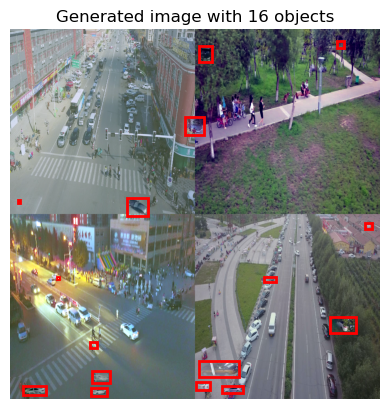

In [8]:
plt.imshow(img)
plt.title(f"Generated image with {num_obj} objects")
for bbox in bboxes:
    x, y, w, h = bbox
    rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
    plt.gca().add_patch(rect)
plt.axis('off')

Text(0.5, 1.0, 'Гистограмма изображения')

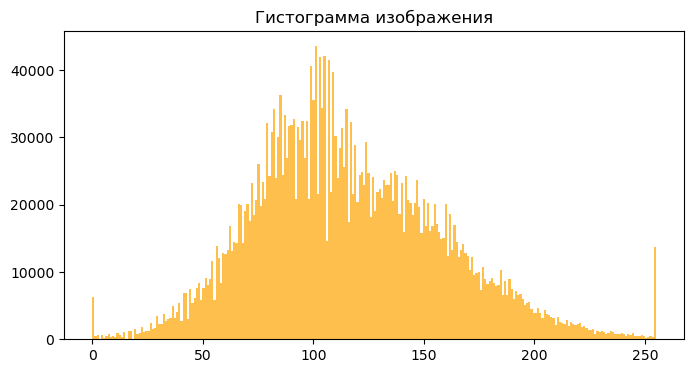

In [9]:
plt.figure(figsize=(8, 4))
plt.hist(img.ravel(), bins=256, color='orange', alpha=0.7)
plt.title('Гистограмма изображения')

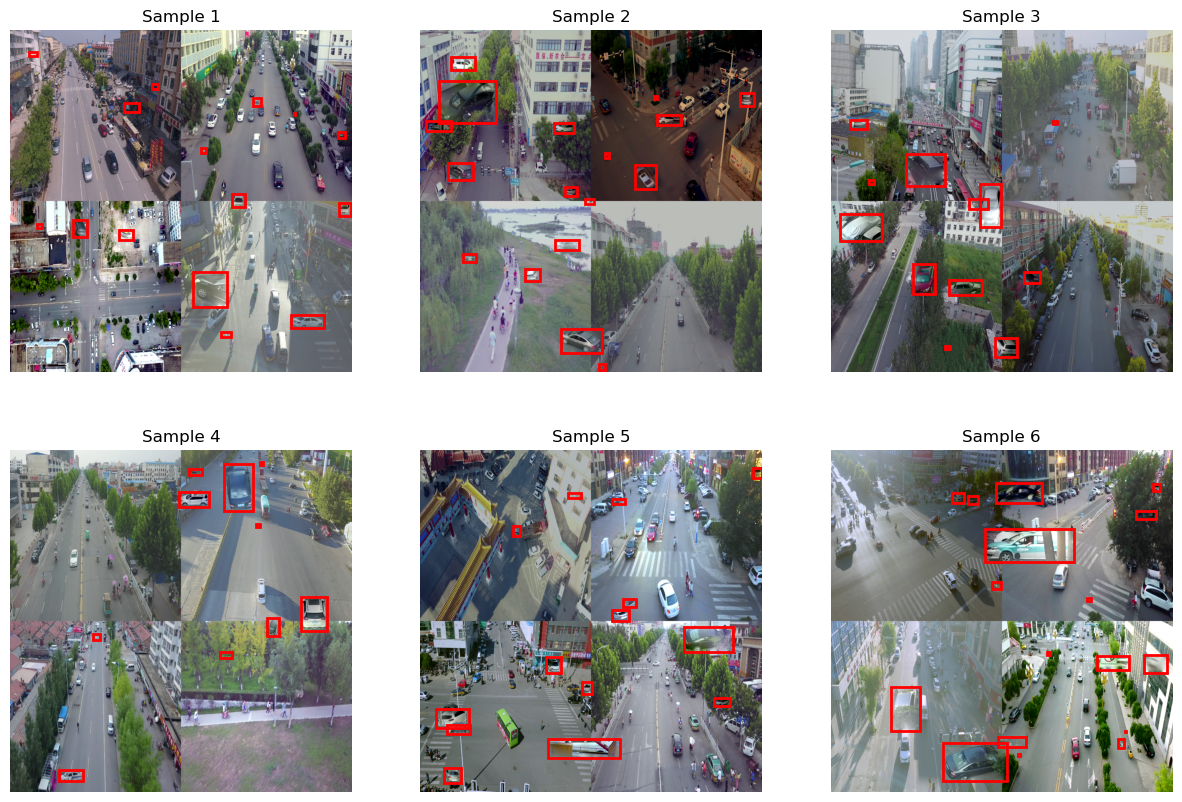

In [10]:
img_gen = ImageGenerator(visdrone, len(visdrone), (512, 512))
figure = plt.figure(figsize=(15, 10))
cols, rows = 3, 2

for i in range(1, cols * rows + 1):
    img, bboxes, obj_num = img_gen[i]
    ax = figure.add_subplot(rows, cols, i)
    ax.imshow(img)
    ax.set_title(f"Sample {i}")
    for bbox in bboxes:
        x, y, w, h = bbox
        rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
    ax.axis('off')